# MNIST: Knet.jl CNN

In this tutorial we will adapt the
[MNIST example](http://denizyuret.github.io/Knet.jl/latest/tutorial.html#Convolutional-neural-network-1)
from [Knet.jl](https://github.com/denizyuret/Knet.jl)
to utilize a custom augmentation pipeline.
In order to showcase the effect that image augmentation can
have on a neural network's ability to generalize, we will
limit the training set to just the first 500 images (of the
available 60,000!). For more information on the dataset see
[MNIST1998].

## Preparing the MNIST dataset

In order to access, prepare, and visualize the MNIST images we
employ the help of three additional Julia packages. In the
interest of time and space we will not go into great detail
about their functionality. Feel free to click on their
respective names to find out more information about the
utility they can provide.

- [MLDatasets.jl](https://github.com/JuliaML/MLDatasets.jl)
  has an MNIST submodule that offers a convenience interface
  to read the MNIST database.

- [Images.jl](https://github.com/JuliaImages/Images.jl) will
  provide us with the necessary tools to process and display
  the image data in Julia / Juypter.

- [MLDataUtils.jl](https://github.com/JuliaML/MLDataUtils.jl)
  implements a variety of functions to convert and partition
  Machine Learning datasets. This will help us prepare the
  MNIST data to be used with Knet.jl.

In [1]:
using Images, MLDatasets, MLDataUtils
srand(42);

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #RegisterDataDep#31(::Function, ::Function, ::Function, ::String, ::String, ::Array{String,1}, ::String) at ./deprecated.jl:57
 [3] RegisterDataDep(::String, ::String, ::Array{String,1}, ::String) at ./deprecated.jl:57
 [4] __init__() at /home/csto/.julia/v0.6/MLDatasets/src/SVHN2/SVHN2.jl:86
 [5] _include_from_serialized(::String) at ./loading.jl:157
 [6] _require_from_serialized(::Int64, ::Symbol, ::String, ::Bool) at ./loading.jl:200
 [7] _require_search_from_serialized(::Int64, ::Symbol, ::String, ::Bool) at ./loading.jl:236
 [8] _require(::Symbol) at ./loading.jl:441
 [9] require(::Symbol) at ./loading.jl:405
 [10] include_string(::String, ::String) at ./loading.jl:522
 [11] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/csto/.julia/v0.6/IJulia/src/execute_request.jl:158
 [12] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/csto/.julia/v0.6/Compat/src/Co

As you may have seen previously in the
[elastic distortions tutorial](@ref elastic), the function
`MNIST.traintensor` returns the MNIST training images
corresponding to the given indices as a multi-dimensional
array. These images are stored in the native horizontal-major
memory layout as a single array. Because we specify that
the `eltype` of that array should be `Float32`, all the
individual values are scaled to be between `0.0` and `1.0`.
Also note, how the observations are laid out along the last
array dimension

In [2]:
@show summary(MNIST.traintensor(Float32, 1:500));

summary(MNIST.traintensor(Float32, 1:500)) = "28×28×500 Array{Float32,3}"


The corresponding label of each image is stored as an integer
value between `0` and `9`. That means that if the label has
the value `3`, then the corresponding image is known to be a
handwritten "3". To show a more concrete example, the
following code reveals that the first training image denotes a
"5" and the second training image a "0" (etc).

In [3]:
@show summary(MNIST.trainlabels(1:500))
println("First eight labels: ", join(MNIST.trainlabels(1:8),", "))

summary(MNIST.trainlabels(1:500)) = "500-element Array{Int64,1}"
First eight labels: 5, 0, 4, 1, 9, 2, 1, 3


For Knet we will require a slightly format for the images
and also the labels. More specifically, we add an additional
singleton dimension of length 1 to our image array. Think of
this as our single color channel (because MNIST images are gray).
Additionally we will convert our labels to proper 1-based indices.
This is because some functions provided by Knet expect the labels
to be in this format. We will do all this by creating a little
utility function that we will name `prepare_mnist`.

In [4]:
"""
    prepare_mnist(images, labels) -> (X, Y)

Change the dimension layout x1×x2×N of the given array
`images` to x1×x2×1×N and return the result as `X`.
The given integer vector `labels` is transformed into
an integer vector denoting 1-based class indices.
"""
function prepare_mnist(images, labels)
    X = reshape(images, (28, 28, 1, :))
    Y = convertlabel(LabelEnc.Indices{Int8}, labels, 0:9)
    X, Y
end

prepare_mnist

With `prepare_mnist` defined, we can now use it in conjunction
with the functions in the `MLDatasets.MNIST` sub-module to load
and prepare our training set. Recall that for this tutorial only
the first 500 images of the training set will be used.

summary(train_x) = "28×28×1×500 Array{Float32,4}"
summary(train_y) = "500-element Array{Int8,1}"


,,,,,,,

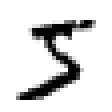
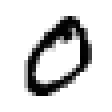
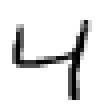
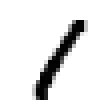
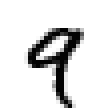
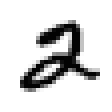
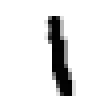
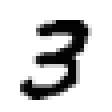

In [5]:
train_x, train_y = prepare_mnist(MNIST.traintensor(Float32, 1:500), MNIST.trainlabels(1:500))
@show summary(train_x) summary(train_y);
[MNIST.convert2image(train_x[:,:,1,i]) for i in 1:8]

Similarly, we use `MNIST.testtensor` and `MNIST.testlabels`
to load the full MNIST test set. We will utilize that data to
measure how well the network is able to generalize with and
without augmentation.

summary(test_x) = "28×28×1×10000 Array{Float32,4}"
summary(test_y) = "10000-element Array{Int8,1}"


,,,,,,,

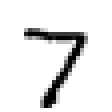
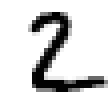
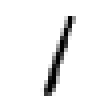
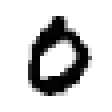
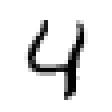
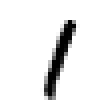
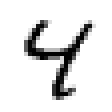
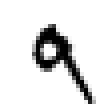

In [6]:
test_x, test_y = prepare_mnist(MNIST.testtensor(Float32), MNIST.testlabels())
@show summary(test_x) summary(test_y);
[MNIST.convert2image(test_x[:,:,1,i]) for i in 1:8]

## Defining the Network

With the dataset prepared, we can now define and instantiate
our neural network. To keep things simple, we will use the same
convolutional network as defined in the
[MNIST example](http://denizyuret.github.io/Knet.jl/latest/tutorial.html#Convolutional-neural-network-1)
of the Knet.jl package.

In [7]:
using Knet

The first thing we will do is define the forward pass through
the network. This will effectively outline the computation
graph of the network architecture. Note how this does not
define some details, such as the number of neurons per layer.
We will define those later when initializing our
vector of weight arrays `w`.

In [8]:
"""
    forward(w, x) -> a

Compute the forward pass for the given minibatch `x` by using the
neural network parameters in `w`. The resulting (unnormalized)
activations of the last layer are returned as `a`.
"""
function forward(w, x)
    # conv1 (2x2 maxpool)
    a1 = pool(relu.(conv4(w[1], x)  .+ w[2]))
    # conv2 (2x2 maxpool)
    a2 = pool(relu.(conv4(w[3], a1) .+ w[4]))
    # dense1 (relu)
    a3 = relu.(w[5] * mat(a2) .+ w[6])
    # dense2 (identity)
    a4 = w[7] * a3 .+ w[8]
    return a4
end

forward

In order to be able to train our network we need to choose a
cost function. Because this is a classification problem we will
use the negative log-likelihood (provided by `Knet.nll`).
With the cost function defined we can the simply use the
higher-order function `grad` to create a new function `costgrad`
that computes us the corresponding gradients.

In [9]:
"""
    cost(w, x, y) -> AbstractFloat

Compute the per-instance negative log-likelihood for the data
in the minibatch `(x, y)` given the network with the current
parameters in `w`.
"""
cost(w, x, y) = nll(forward(w, x), y)
costgrad = grad(cost)

(::gradfun) (generic function with 1 method)

Aside from the cost function that we need for training, we
would also like a more interpretable performance measurement.
In this tutorial we will use "accuracy" for its simplicity
and because we know that the class distribution for MNIST
is close to uniform.

In [10]:
"""
    acc(w, X, Y; [batchsize]) -> Float64

Compute the accuracy for the data in `(X,Y)` given the network
with the current parameters in `w`. The resulting value is
computed by iterating over the data in minibatches of size
`batchsize`.
"""
function acc(w, X, Y; batchsize = 100)
    sum = 0; count = 0
    for (x_cpu, y) in eachbatch((X, Y), maxsize = batchsize)
        x = KnetArray{Float32}(x_cpu)
        sum += Int(accuracy(forward(w,x), y, average = false))
        count += length(y)
    end
    return sum / count
end

acc

Before we can train or even just use our network, we need to
define how we initialize `w`, which is our the vector of
parameter arrays. The dimensions of these individual arrays
specify the filter sizes and number of neurons.
It can be helpful to compare the indices here with the indices
used in our `forward` function to see which array corresponds
to which computation node of our network.

In [11]:
function weights(atype = KnetArray{Float32})
    w = Array{Any}(8)
    # conv1
    w[1] = xavier(5,5,1,20)
    w[2] = zeros(1,1,20,1)
    # conv2
    w[3] = xavier(5,5,20,50)
    w[4] = zeros(1,1,50,1)
    # dense1
    w[5] = xavier(500,800)
    w[6] = zeros(500,1)
    # dense2
    w[7] = xavier(10,500)
    w[8] = zeros(10,1)
    return map(a->convert(atype,a), w)
end

weights (generic function with 2 methods)

## Training without Augmentation

In order to get an intuition for how useful augmentation can
be, we need a sensible baseline to compare to. To that end, we
will first train the network we just defined using only the
(unaltered) 500 training examples.

The package
[ValueHistories.jl](https://github.com/JuliaML/ValueHistories.jl)
will help us record the accuracy during the training process.
We will use those logs later to visualize the differences
between having augmentation or no augmentation.

In [12]:
using ValueHistories

To keep things simple, we will not overly optimize our
training function. Thus, we will be content with using a
closure. Because both, the baseline and the augmented version,
will share this "inefficiency", we should still get a decent
enough picture of their performance differences.

In [13]:
function train_baseline(; epochs = 500, batchsize = 100, lr = .03)
    w = weights()
    log = MVHistory()
    for epoch in 1:epochs
        for (batch_x_cpu, batch_y) in eachbatch((train_x ,train_y), batchsize)
            batch_x = KnetArray{Float32}(batch_x_cpu)
            g = costgrad(w, batch_x, batch_y)
            Knet.update!(w, g, lr = lr)
        end

        if (epoch % 5) == 0
            train = acc(w, train_x, train_y)
            test  = acc(w, test_x,  test_y)
            @trace log epoch train test
            msg = "epoch " * lpad(epoch,4) * ": train accuracy " * rpad(round(train,3),5,"0") * ", test accuracy " * rpad(round(test,3),5,"0")
            println(msg)
        end
    end
    log
end

train_baseline (generic function with 1 method)

Aside from the accuracy, we will also keep an eye on the
training time. In particular we would like to see if and how
the addition of augmentation causes our training time to
increase.

In [14]:
train_baseline(epochs=1) # warm-up
baseline_log = @time train_baseline(epochs=200);

epoch    5: train accuracy 0.550, test accuracy 0.460
epoch   10: train accuracy 0.694, test accuracy 0.592
epoch   15: train accuracy 0.820, test accuracy 0.749
epoch   20: train accuracy 0.862, test accuracy 0.781
epoch   25: train accuracy 0.888, test accuracy 0.815
epoch   30: train accuracy 0.896, test accuracy 0.850
epoch   35: train accuracy 0.920, test accuracy 0.867
epoch   40: train accuracy 0.930, test accuracy 0.875
epoch   45: train accuracy 0.938, test accuracy 0.882
epoch   50: train accuracy 0.952, test accuracy 0.885
epoch   55: train accuracy 0.964, test accuracy 0.889
epoch   60: train accuracy 0.968, test accuracy 0.891
epoch   65: train accuracy 0.974, test accuracy 0.893
epoch   70: train accuracy 0.978, test accuracy 0.894
epoch   75: train accuracy 0.982, test accuracy 0.896
epoch   80: train accuracy 0.988, test accuracy 0.898
epoch   85: train accuracy 0.994, test accuracy 0.899
epoch   90: train accuracy 0.996, test accuracy 0.899
epoch   95: train accuracy 0

As we can see, the accuracy on the training set is around a
100%, while the accuracy on the test set peaks around 90%. For
a mere 500 training examples, this isn't actually that bad of
a result.

## Integrating Augmentor

Now that we have a network architecture with a baseline to
compare to, let us finally see what it takes to add Augmentor
to our experiment. First, we need to include the package to
our experiment.

In [15]:
using Augmentor

The next step, and maybe the most human-hour consuming part of
adding image augmentation to a prediction problem, is to
design and select a sensible augmentation pipeline. Take a
look at the [elastic distortions tutorial](@ref elastic) for
an example of how to do just that.

For this example, we already choose a quite complicated but
promising augmentation pipeline for you. This pipeline was
designed to yield a large variation of effects as well as to
showcase how even deep pipelines are quite efficient in terms
of performance.

In [16]:
pl = Reshape(28,28) |>
     PermuteDims(2,1) |>
     ShearX(-5:5) * ShearY(-5:5) |>
     Rotate(-15:15) |>
     CropSize(28,28) |>
     Zoom(0.9:0.1:1.2) |>
     CacheImage() |>
     ElasticDistortion(10) |>
     PermuteDims(2,1) |>
     Reshape(28,28,1)

10-step Augmentor.ImmutablePipeline:
  1.) Reshape array to 28×28
  2.) Permute dimension order to (2, 1)
  3.) Either: (50%) ShearX by ϕ ∈ -5:5 degree. (50%) ShearY by ψ ∈ -5:5 degree.
  4.) Rotate by θ ∈ -15:15 degree
  5.) Crop a 28×28 window around the center
  6.) Zoom by I ∈ {0.9×0.9, 1.0×1.0, 1.1×1.1, 1.2×1.2}
  7.) Cache into temporary buffer
  8.) Distort using a smoothed and normalized 10×10 grid with pinned border
  9.) Permute dimension order to (2, 1)
 10.) Reshape array to 28×28×1

Most of the used operations are quite self explanatory, but
there are some details about this pipeline worth pointing out
explicitly.

1. We use the operation [`PermuteDims`](@ref) to convert the
   horizontal-major MNIST image to a julia-native
   vertical-major image. The vertical-major image is then
   processed and converted back to a horizontal-major array.
   We mainly do this here to showcase the option, but it is
   also to keep consistent with how the data is usually used
   in the literature. Alternatively, one could just work with
   the MNIST data in a vertical-major format all the way
   through without any issue.

2. As counter-intuitive as it sounds, the operation
   [`CacheImage`](@ref) right before
   [`ElasticDistortion`](@ref) is actually used to improve
   performance. If we were to omit it, then the whole pipeline
   would be applied in one single pass. In this case, applying
   distortions on top of affine transformations lazily is in
   fact less efficient than using a temporary variable.

With the pipeline now defined, let us quickly peek at what
kind of effects we can achieve with it. In particular, lets
apply the pipeline multiple times to the first training image
and look at what kind of results it produces.

,
,
,
,
,
,
,
,

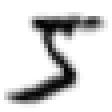
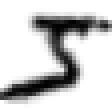
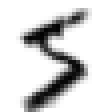
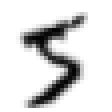
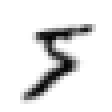
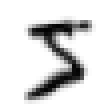
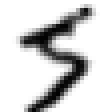
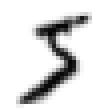
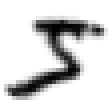
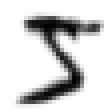
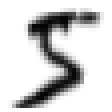
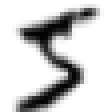
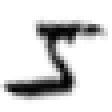
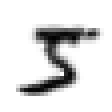
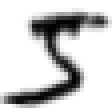
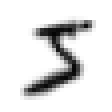

In [17]:
[MNIST.convert2image(reshape(augment(train_x[:,:,:,1], pl), (28, 28))) for j in 1:8, i in 1:2]

As we can see, we can achieve a wide range of effects, from
more subtle to more pronounced. The important part is that all
examples are still clearly representative of the true label.

Next, we have to adapt the function `train_baseline` to make
use of our augmentation pipeline. To integrate Augmentor
efficiently, there are three necessary changes we have to
make.

1. Preallocate a buffer with the same size and element type
   that each batch has.

   ```
   batch_x_aug = zeros(Float32, 28, 28, 1, batchsize)
   ```

2. Add a call to [`augmentbatch!`](@ref) in the inner loop of
   the batch iterator using our pipeline and buffer.

   ```
   augmentbatch!(batch_x_aug, batch_x_org, pl)
   ```

3. Replace `batch_x_org` with `batch_x_aug` in the constructor
   of `KnetArray`.

   ```
   batch_x = KnetArray{Float32}(batch_x_aug)
   ```

Applying these changes to our `train_baseline` function
will give us something similar to the following function.
Note how all the other parts of the function remain exactly
the same as before.

In [18]:
function train_augmented(; epochs = 500, batchsize = 100, lr = .03)
    w = weights()
    log = MVHistory()
    batch_x_aug = zeros(Float32, size(train_x,1), size(train_x,2), 1, batchsize)
    for epoch in 1:epochs
        for (batch_x_cpu, batch_y) in eachbatch((train_x ,train_y), batchsize)
            augmentbatch!(CPUThreads(), batch_x_aug, batch_x_cpu, pl)
            batch_x = KnetArray{Float32}(batch_x_aug)
            g = costgrad(w, batch_x, batch_y)
            Knet.update!(w, g, lr = lr)
        end

        if (epoch % 5) == 0
            train = acc(w, train_x, train_y)
            test  = acc(w, test_x,  test_y)
            @trace log epoch train test
            msg = "epoch " * lpad(epoch,4) * ": train accuracy " * rpad(round(train,3),5,"0") * ", test accuracy " * rpad(round(test,3),5,"0")
            println(msg)
        end
    end
    log
end

train_augmented (generic function with 1 method)

You may have noticed in the code above that we also pass a
`CPUThreads()` as the first argument to [`augmentbatch!`](@ref).
This instructs Augmentor to process the images of the batch in
parallel using multi-threading. For this to work properly you
will need to set the environment variable `JULIA_NUM_THREADS`
to the number of threads you wish to use. You can check how
many threads are used with the function `Threads.nthreads()`

In [19]:
@show Threads.nthreads();

Threads.nthreads() = 10


Now that all pieces are in place, let us train our network
once more. We will use the same parameters except that now
instead of the original training images we will be using
randomly augmented images. This will cause every epoch to be
different.

In [20]:
train_augmented(epochs=1) # warm-up
augmented_log = @time train_augmented(epochs=200);

epoch    5: train accuracy 0.520, test accuracy 0.462
epoch   10: train accuracy 0.658, test accuracy 0.564
epoch   15: train accuracy 0.732, test accuracy 0.678
epoch   20: train accuracy 0.786, test accuracy 0.728
epoch   25: train accuracy 0.828, test accuracy 0.778
epoch   30: train accuracy 0.884, test accuracy 0.846
epoch   35: train accuracy 0.870, test accuracy 0.822
epoch   40: train accuracy 0.916, test accuracy 0.873
epoch   45: train accuracy 0.912, test accuracy 0.866
epoch   50: train accuracy 0.914, test accuracy 0.876
epoch   55: train accuracy 0.936, test accuracy 0.887
epoch   60: train accuracy 0.944, test accuracy 0.910
epoch   65: train accuracy 0.940, test accuracy 0.901
epoch   70: train accuracy 0.932, test accuracy 0.888
epoch   75: train accuracy 0.952, test accuracy 0.910
epoch   80: train accuracy 0.952, test accuracy 0.905
epoch   85: train accuracy 0.968, test accuracy 0.929
epoch   90: train accuracy 0.972, test accuracy 0.927
epoch   95: train accuracy 0

As we can see, our network reaches far better results on our
testset than our baseline network did. However, we can also
see that the training took quite a bit longer than before.
This difference generally decreases as the complexity of the
utilized neural network increases. Yet another way to improve
performance (aside from simplifying the augmentation pipeline)
would be to increase the number of available threads.

## Improving Performance

One of the most effective ways to make the most out of the
available resources is to augment the next (couple) mini-batch
while the current minibatch is being processed on the GPU.
We can do this via julia's build in parallel computing
capabilities

First we need a worker process that will be responsible for
augmenting our dataset each epoch. This worker also needs
access to a couple of our packages

In [21]:
# addprocs(1)
# @everywhere using Augmentor, MLDataUtils

Next, we replace the inner `eachbatch` loop with a more
complicated version using a `RemoteChannel` to exchange and
queue the augmented data.

In [22]:
function async_train_augmented(; epochs = 500, batchsize = 100, lr = .03)
    w = weights()
    log = MVHistory()
    for epoch in 1:epochs
        @sync begin
            local_ch = Channel{Tuple}(4) # prepare up to 4 minibatches in adavnce
            remote_ch = RemoteChannel(()->local_ch)
            @spawn begin
                # This block is executed on the worker process
                batch_x_aug = zeros(Float32, size(train_x,1), size(train_x,2), 1, batchsize)
                for (batch_x_cpu, batch_y) in eachbatch((train_x ,train_y), batchsize)
                    # we are still using multithreading
                    augmentbatch!(CPUThreads(), batch_x_aug, batch_x_cpu, pl)
                    put!(remote_ch, (batch_x_aug, batch_y))
                end
                close(remote_ch)
            end
            @async begin
                # This block is executed on the main process
                for (batch_x_aug, batch_y) in local_ch
                    batch_x = KnetArray{Float32}(batch_x_aug)
                    g = costgrad(w, batch_x, batch_y)
                    Knet.update!(w, g, lr = lr)
                end
            end
        end

        if (epoch % 5) == 0
            train = acc(w, train_x, train_y)
            test  = acc(w, test_x,  test_y)
            @trace log epoch train test
            msg = "epoch " * lpad(epoch,4) * ": train accuracy " * rpad(round(train,3),5,"0") * ", test accuracy " * rpad(round(test,3),5,"0")
            println(msg)
        end
    end
    log
end

async_train_augmented (generic function with 1 method)

Note that for this toy example the overhead of this approach
is greater than the benefit.

## Visualizing the Results

Before we end this tutorial, let us make use the
[Plots.jl](https://github.com/JuliaPlots/Plots.jl) package to
visualize and discuss the recorded training curves.
We will plot the accuracy curves of both networks side by side
in order to get a good feeling about their differences.

In [23]:
using Plots
pyplot()

Plots.PyPlotBackend()

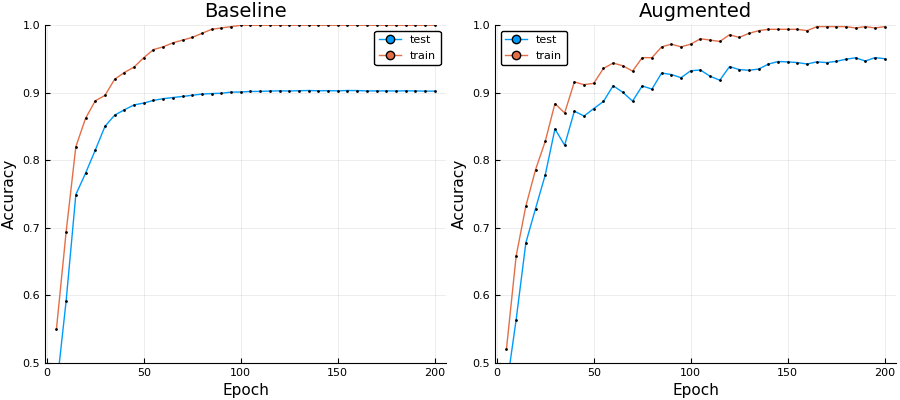

In [24]:
plt = plot(
    plot(baseline_log,  title="Baseline",  ylim=(.5,1)),
    plot(augmented_log, title="Augmented", ylim=(.5,1)),
    size = (900, 400),
    xlab = "Epoch",
    ylab = "Accuracy",
    markersize = 1
)
plt

Note how the accuracy on the (unaltered) training set
increases faster for the baseline network than for the
augmented one. This is to be expected, since our augmented
network doesn't actually use the unaltered images for
training, and thus has not actually seen them. Given this
information, it is worth pointing out explicitly how the
accuracy on training set is still greater than on the test set
for the augmented network as well. This is also not a
surprise, given that the augmented images are likely more
similar to their original ones than to the test images.

For the baseline network, the accuracy on the test set
plateaus quite quickly (around 90%). For the augmented network
on the other hand, it the accuracy keeps increasing for quite
a while longer.

## References

**MNIST1998**: LeCun, Yan, Corinna Cortes, Christopher J.C. Burges. ["The MNIST database of handwritten digits"](http://yann.lecun.com/exdb/mnist/) Website. 1998.